---
title: Dimensionality projections and topology diagnostics
summary: An example of how to use dimensionality projections with the package `topometry`, with some usage of diagnostic tools for comparison of distortions and visualization of eigenvectors.
author: Samuele Soraggi
date-modified: last-modified
date-format: long
date: 2024-09-11
bibliography: ../resources/references.bib
---

# Notebook setup

Here we install some packages, download a file with scripts and the data from the github repository

In [1]:
%pip install --quiet scanpy topometry hnswlib pacmap plotly igraph leidenalg scvelo jupyterquiz git+https://github.com/DmitryUlyanov/Multicore-TSNE.git

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s e

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from scipy.cluster import hierarchy as sch
import re
import pacmap
import topo as tp
import scvelo as scv
from jupyterquiz import display_quiz

from matplotlib import pyplot as plt

import scanpy as sc

%matplotlib inline

In [3]:
scv.set_figure_params('scvelo', dpi=100, fontsize=14, dpi_save=600, format='tif')

In [4]:
!wget -q https://github.com/hds-sandbox/scverse-2024-workshop/raw/main/Scripts/scripts.py

In [5]:
%run scripts.py

In [6]:
!wget https://github.com/hds-sandbox/scverse-2024-workshop/raw/main/Data/testis.h5ad.gz
!gunzip testis.h5ad.gz

--2024-09-09 10:15:17--  https://github.com/hds-sandbox/scverse-2024-workshop/raw/main/Data/testis.h5ad.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Data/testis.h5ad.gz [following]
--2024-09-09 10:15:18--  https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Data/testis.h5ad.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57702152 (55M) [application/octet-stream]
Saving to: ‘testis.h5ad.gz’

testis.h5ad.gz      100%[===================>]  55.03M   343MB/s    in 0.2s    

2024-09-09 10:15:19 (343 MB/s) - ‘testis.h5ad.gz’ saved [5

## Data

The dataset is from human testicular tissue. This contains spermatogonia cells which are the beginning of the differentiation process, which leads to elongated spermatids, which will finally become spermatozoa. Other somatic cell types assist the differentiation and movement of cells in the testicles.

The dataset is a subsample of 10,000 cells from ([Winge et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32449318/)), already filtered down to 7765 cells. The full data [is downloadable](https://cells.ucsc.edu/?ds=testis) and you can find the exact filtering procedure in our [summer school tutorial](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/nb/04_scRNAseq_analysis.html).

In [19]:
adata = sc.read("testis.h5ad")

You can look at the object size and content here. We mostly have some cell-related QC measures in `obs`, and the number of cells expressing each gene in `var`.

In [20]:
adata

AnnData object with n_obs × n_vars = 7765 × 27897
    obs: 'batch', 'super_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'perc_mito', 'perc_MALAT1', 'n_genes'
    var: 'n_cells'

Here we proceed with just a rough normalization in the interest of time (transcript per million + logarithm + standardization). In the meanwhile we determine the 5000 most variable genes. A bit more info on normalization [here](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/nb/04_scRNAseq_analysis.html) if you want to read.

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pp.scale(adata, max_value=10)

# Projections

We start with the usual projection methods everyone starts with after preprocessing, PCA.

PCA is usually the starting point of most calculations in scRNA analysis.

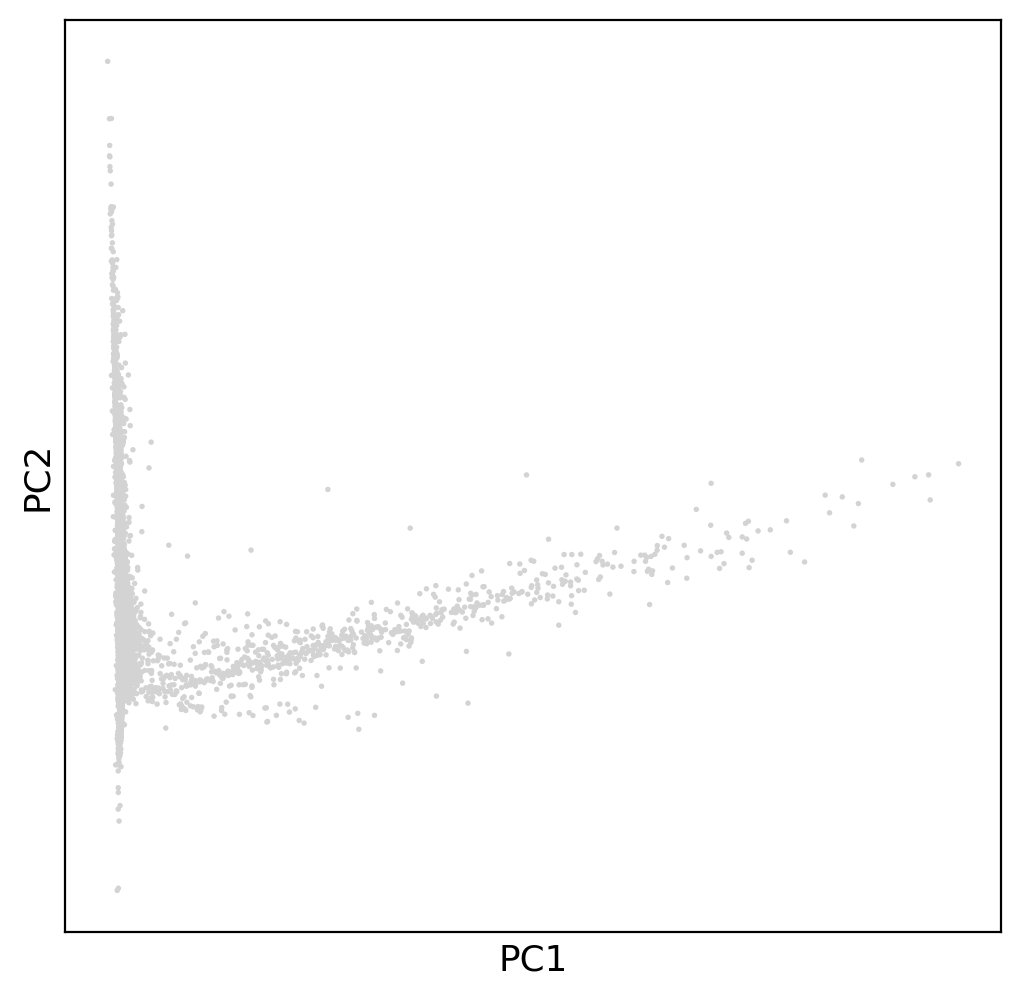

In [22]:
sc.pp.pca(adata) #calculate PCA
plt.rcParams['figure.figsize']=(6,6)
sc.pl.pca(adata) #plot PCA

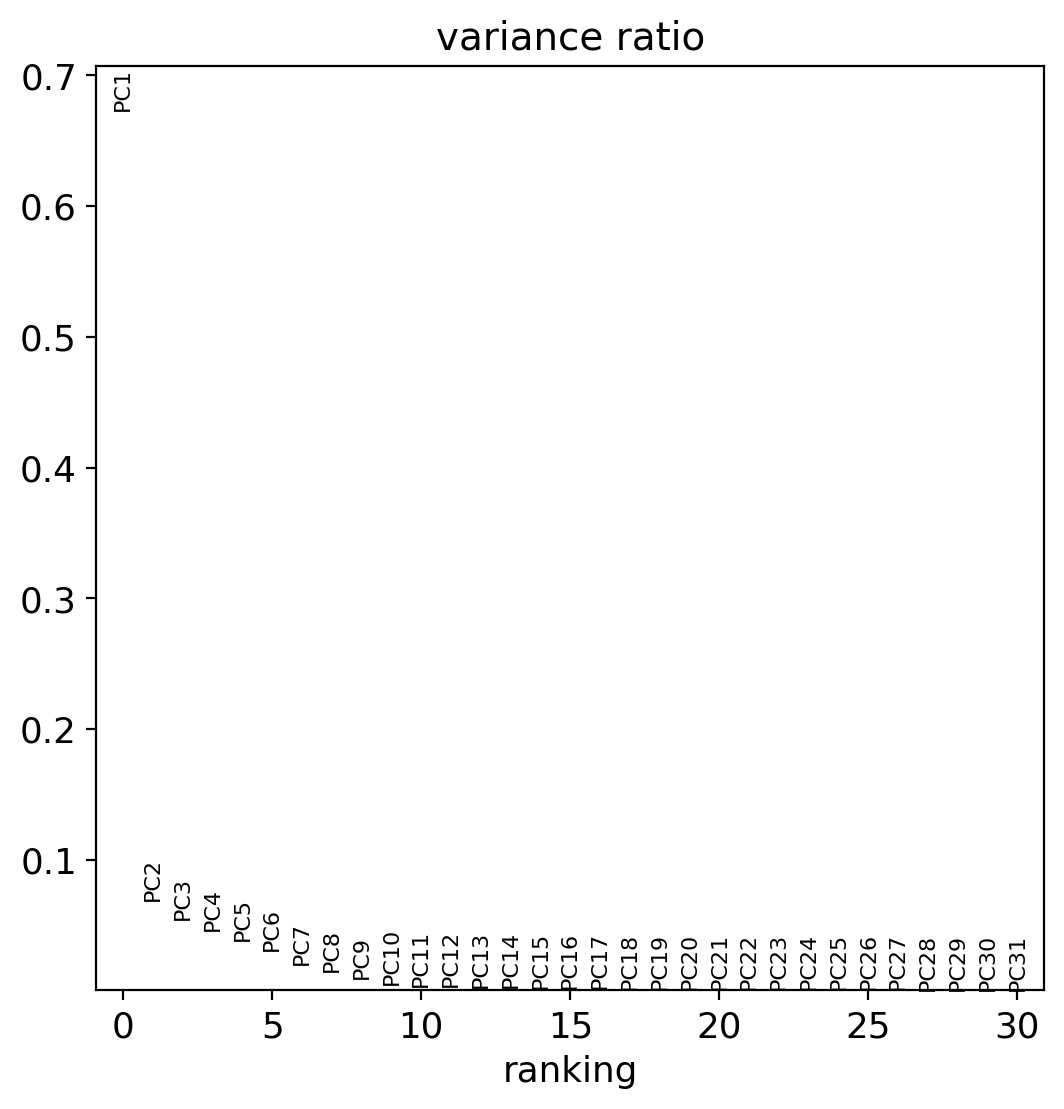

In [23]:
sc.pl.pca_variance_ratio(adata)

In [ ]:
sc.pp.neighbors(adata, n_pcs=10)

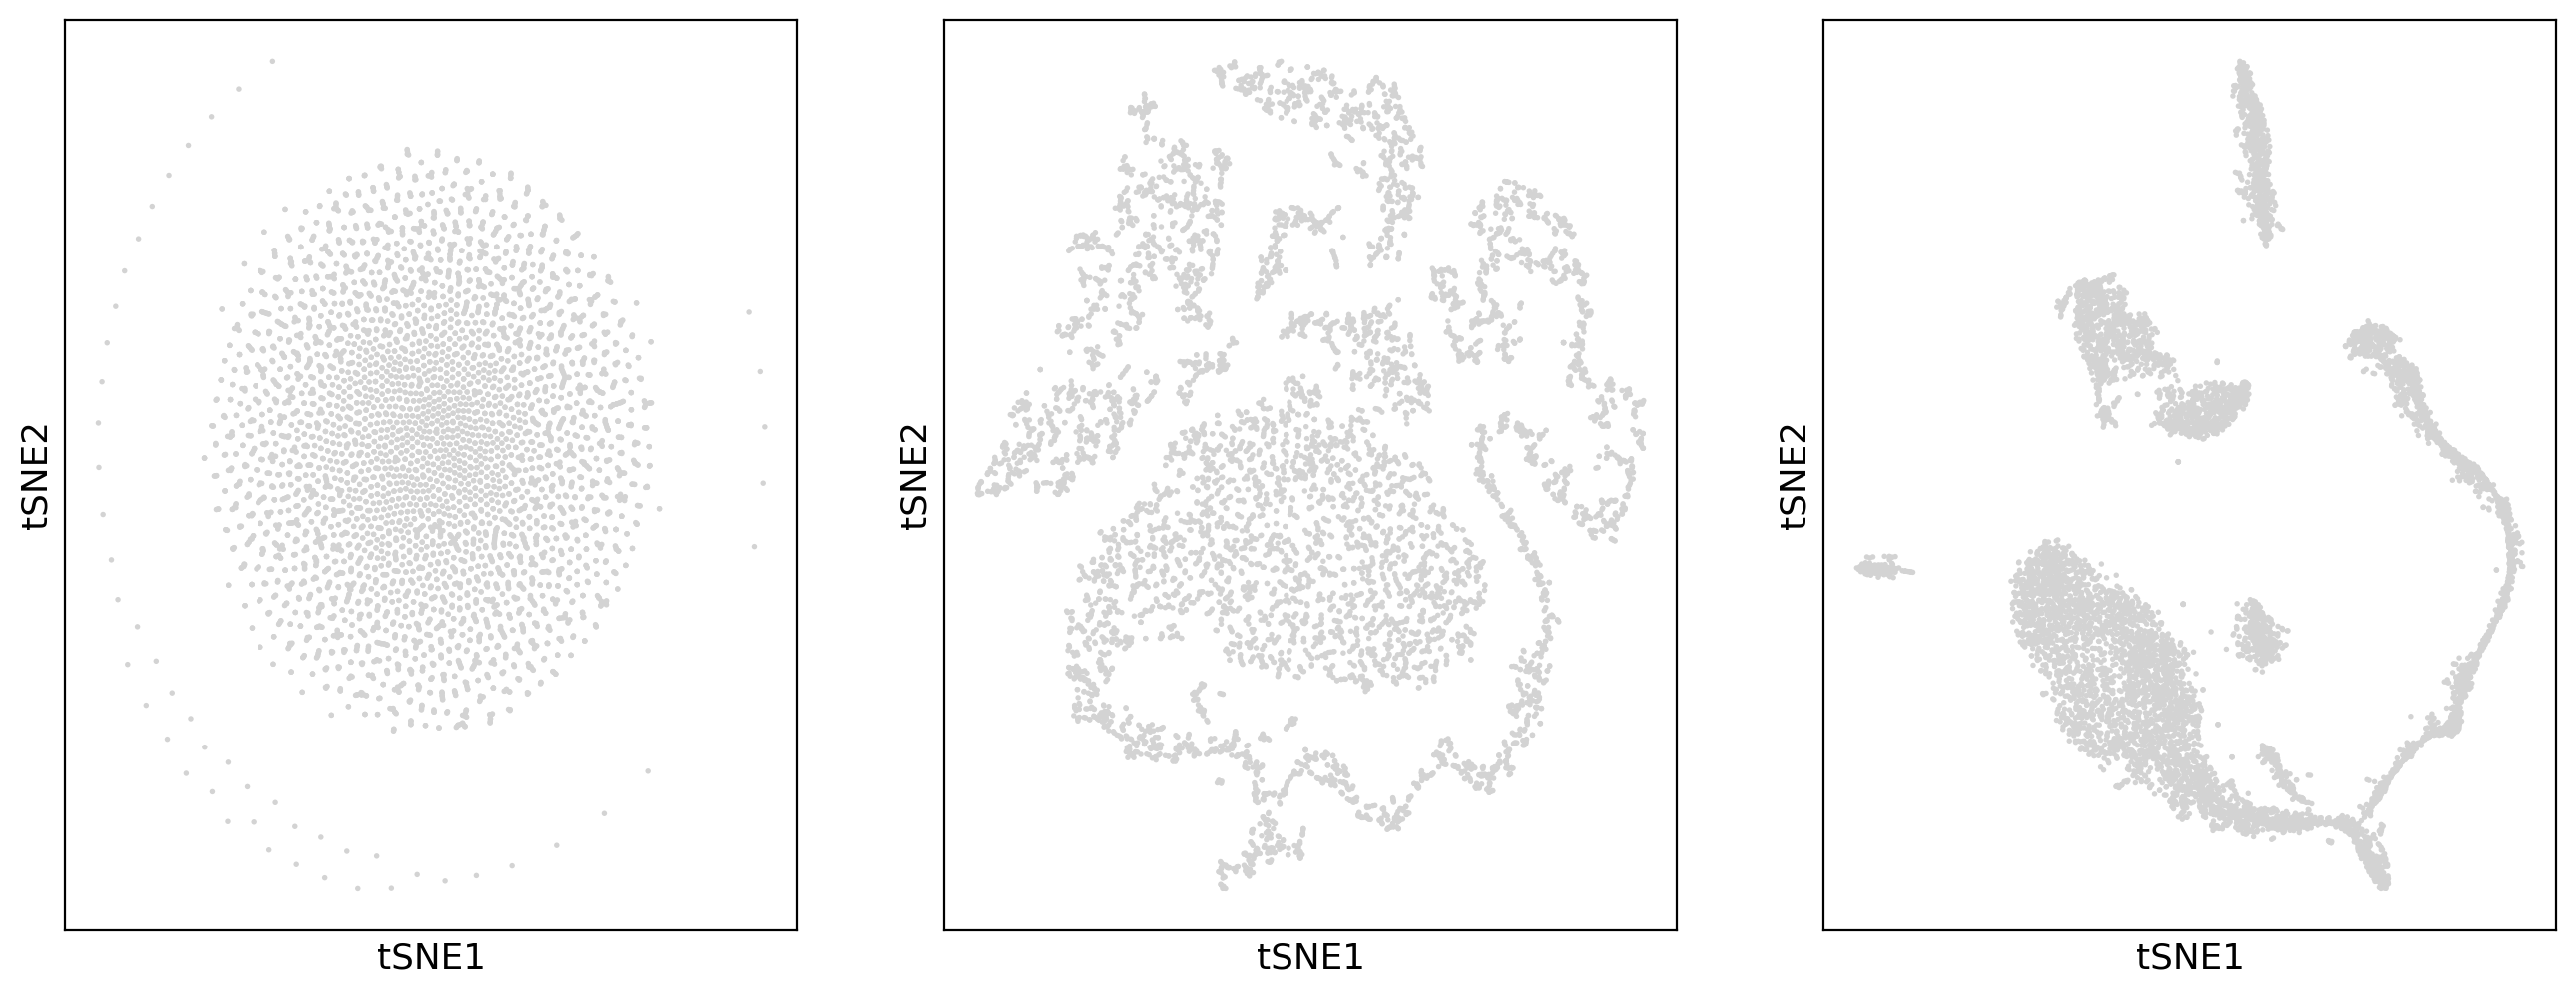

In [16]:
fig, axs = plt.subplots(1,3)
plt.rcParams['figure.figsize']=(6,16)
perps = [1,10,100]
for i in range(3):
  sc.tl.tsne(adata, perplexity=perps[i], n_jobs=4, n_pcs=8)
  sc.pl.tsne(adata, ax=axs[i], show=i==2)

In [12]:
#| echo: false
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz01.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

In [17]:
sc.tl.umap(adata, a=1, b=1)

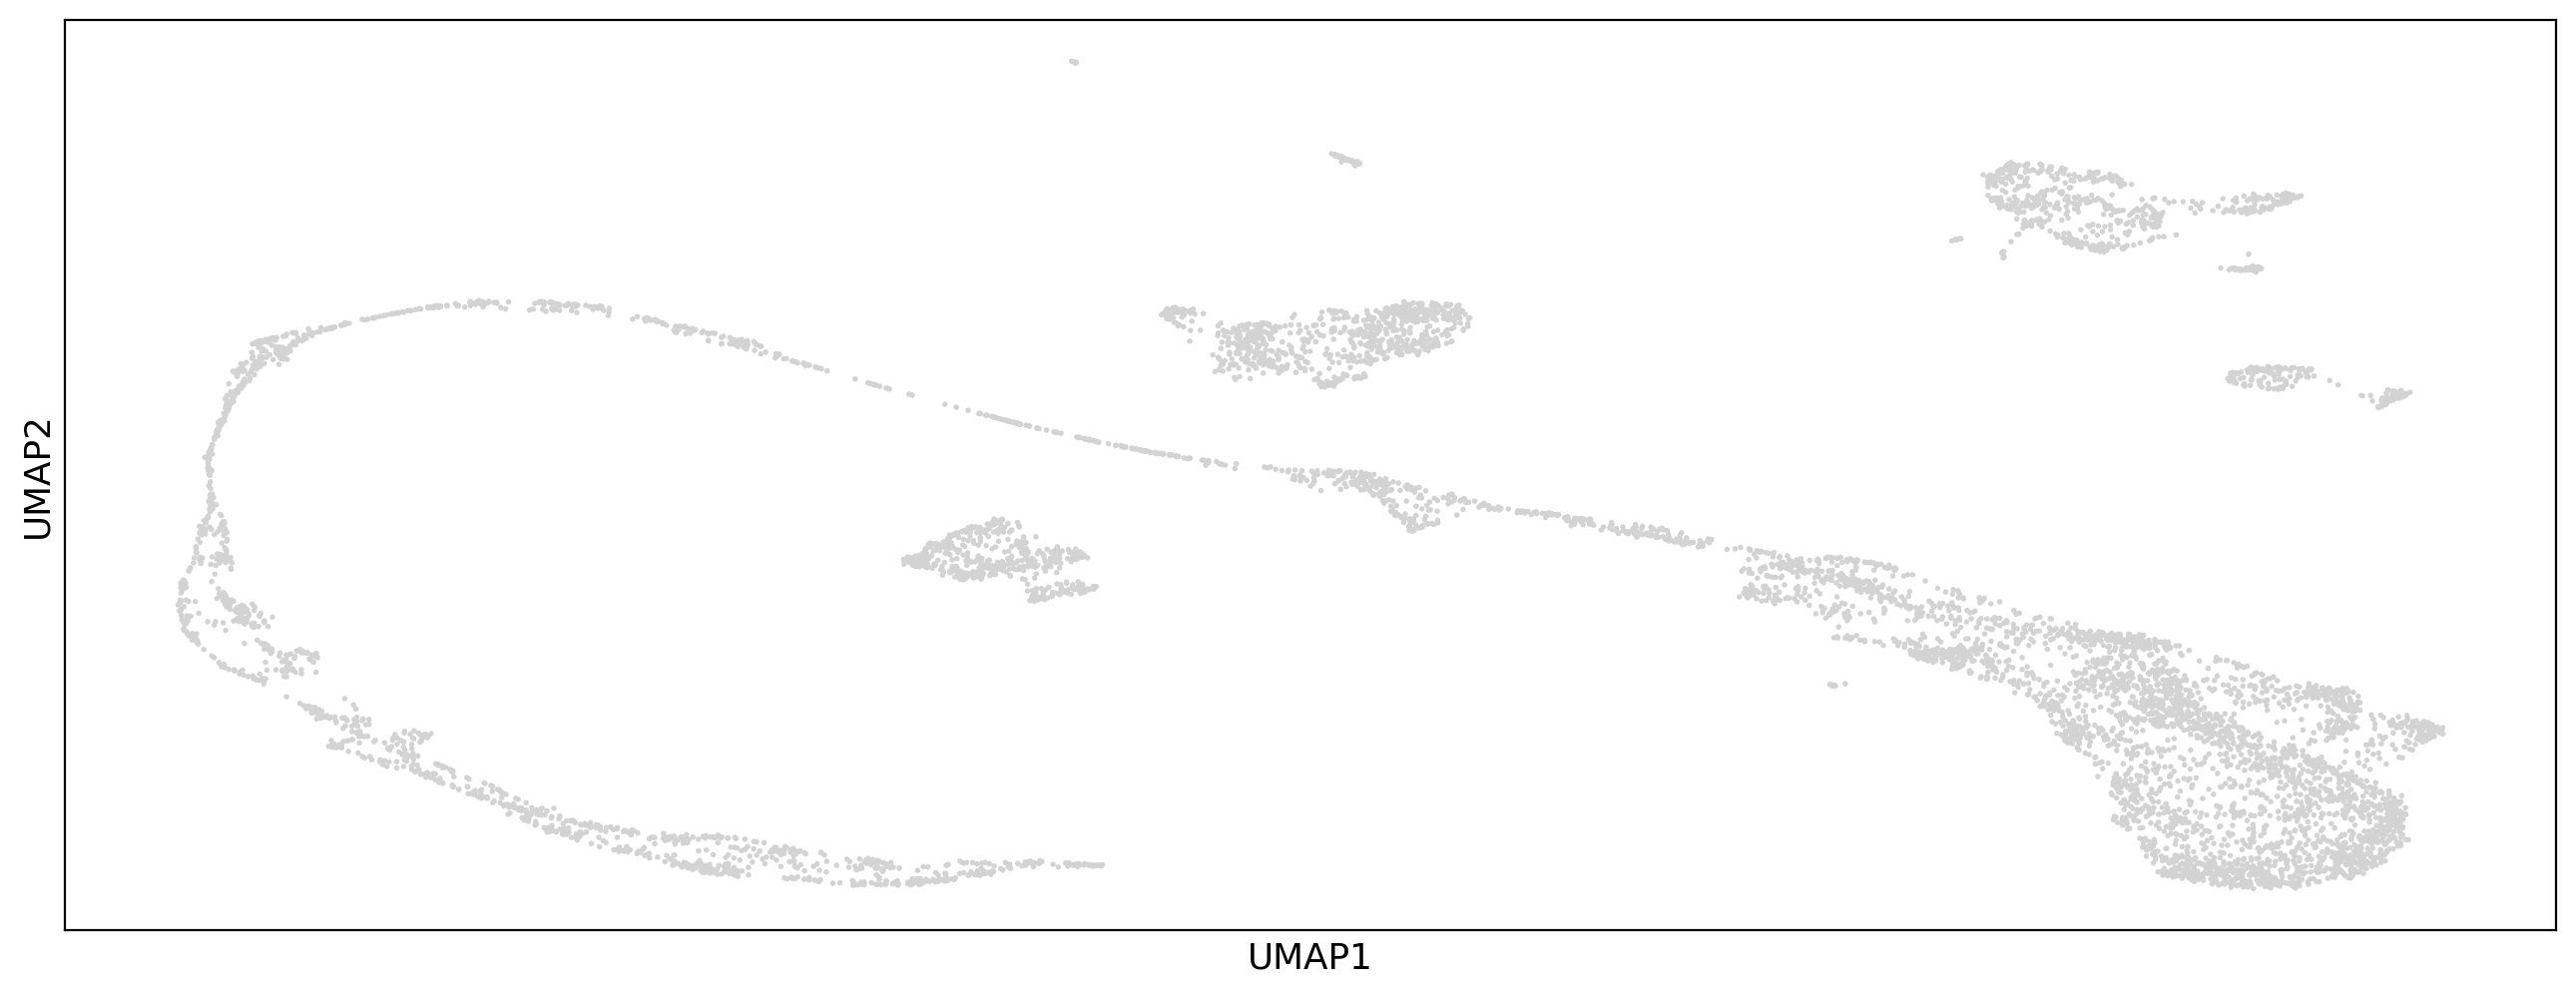

In [18]:
fig, axs = plt.subplots(1)
plt.rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata, ax=axs, show=True)

In [ ]:
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz02.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

In [ ]:
adataHVG = adata[:, adata.var.highly_variable].copy()

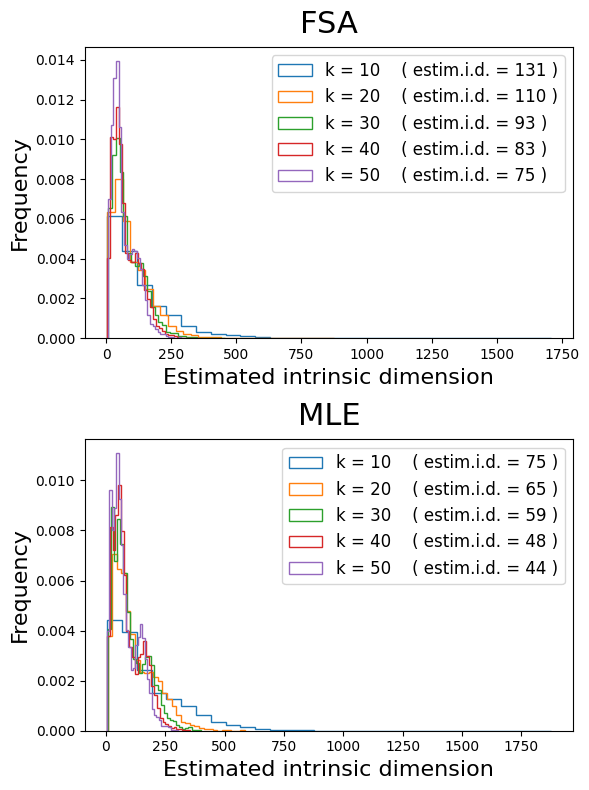

In [ ]:
tp.tpgraph.IntrinsicDim(
        methods=['fsa','mle'],
        k=range(10, 60, 10),
        backend='hnswlib',
        metric='euclidean',
        n_jobs=-1,
        plot=True,
        random_state=None).fit(adataHVG.X)

In [ ]:
# Run TopOMetry

# Create a TopOGraph object with the desired parameters
tg = tp.TopOGraph(n_eigs=250, n_jobs=-1, verbosity=1, random_state=42)

# Fit some models to the data
adata = tp.sc.topological_workflow(adata, tg,
                                  kernels=['bw_adaptive'],
                                  eigenmap_methods=['LE'],
                                  projections=['MAP', 'PaCMAP'])

Computing neighborhood graph...
 Base kNN graph computed in 67.042537 (sec)
 Fitted the bw_adaptive kernel in 0.930721 (sec)
Computing eigenbasis...
 Fitted eigenbasis with Laplacian Eigenmaps from the bw_adaptive in 25.943049 (sec)
    Building topological graph from eigenbasis...
        Computing neighborhood graph...
 Computed in 0.572760 (sec)
 Fitted the bw_adaptive graph kernel in 0.920069 (sec)
 Computed MAP in 9.491873 (sec)
 Computed PaCMAP in 20.034234 (sec)


In [ ]:
adata

AnnData object with n_obs × n_vars = 7765 × 27897
    obs: 'batch', 'super_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'perc_mito', 'perc_MALAT1', 'n_genes', 'bw_adaptive from LE with bw_adaptive_leiden', 'topo_leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'bw_adaptive from LE with bw_adaptive_leiden', 'topo_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_LE with bw_adaptive', 'X_MAP of bw_adaptive from LE with bw_adaptive', 'X_PaCMAP of LE with bw_adaptive', 'X_topoMAP', 'X_topoPaCMAP'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'LE with bw_adaptive_distances', 'bw_adaptive from LE with bw_adaptive_connectivities'

In [ ]:
adata.obsm['X_topoMAP'] = adata.obsm['X_MAP of bw_adaptive from LE with bw_adaptive']
adata.obsm['X_topoPaCMAP'] = adata.obsm['X_PaCMAP of LE with bw_adaptive']
adata.obs['topo_leiden'] = adata.obs['bw_adaptive from LE with bw_adaptive_leiden']

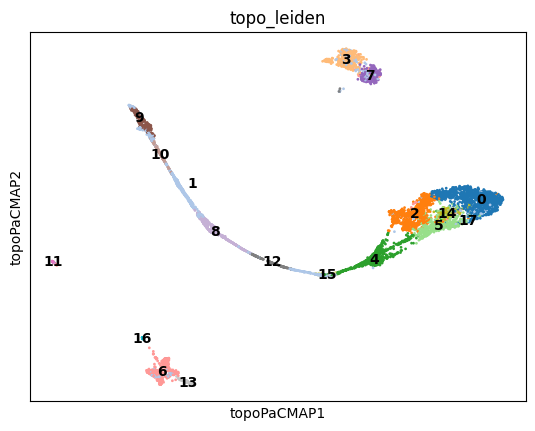

In [ ]:
sc.pl.embedding(adata, basis='topoPaCMAP', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

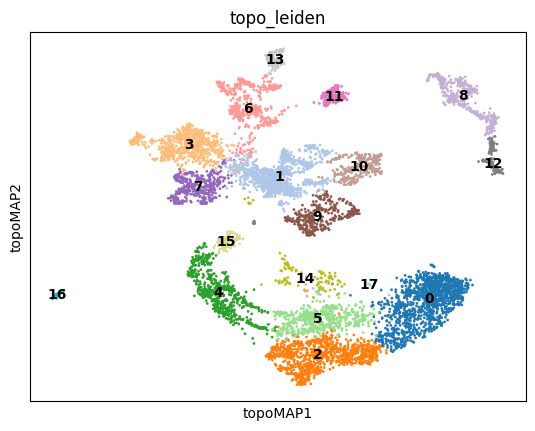

In [ ]:
sc.pl.embedding(adata, basis='topoMAP', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

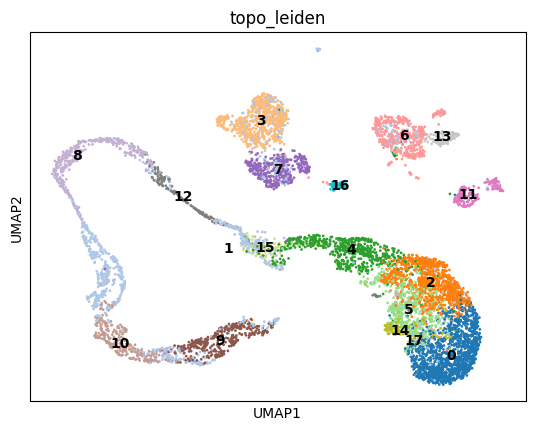

In [ ]:
sc.pl.embedding(adata, basis='umap', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

In [ ]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8']
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM', 'GATA4']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']
markers['Smooth_Muscle'] = ['RGS5']

In [ ]:
markers_scores, adata = marker_score(markers, adata)

In [ ]:
adata.obs['clusters'] = clustersByScores(adata, markers_scores, leidenClusters=adata.obs['topo_leiden'])

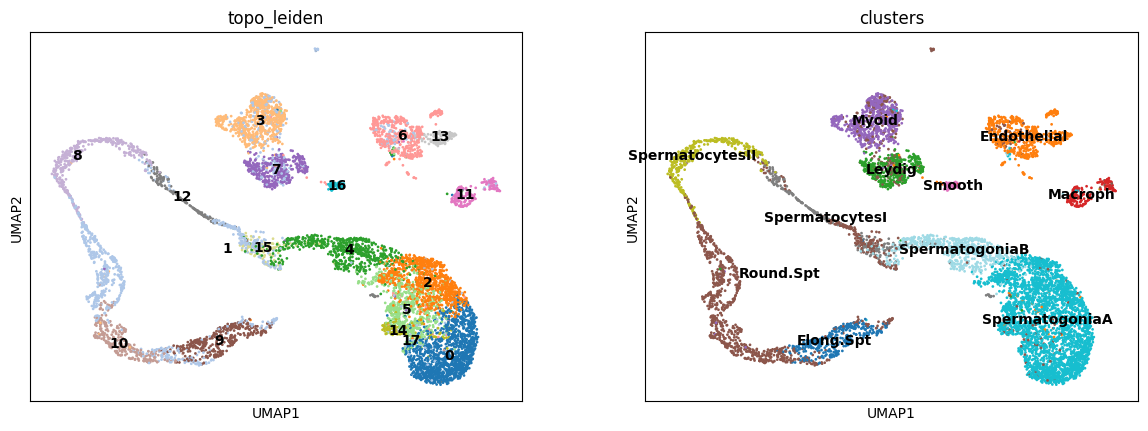

In [ ]:
sc.pl.embedding(adata, basis='umap', color=['topo_leiden','clusters'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

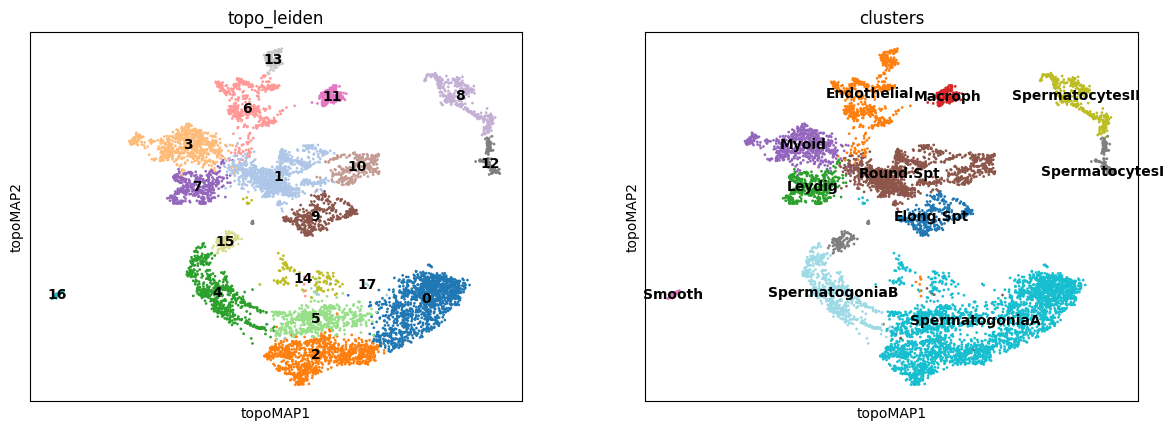

In [ ]:
sc.pl.embedding(adata, basis='topoMAP', color=['topo_leiden','clusters'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

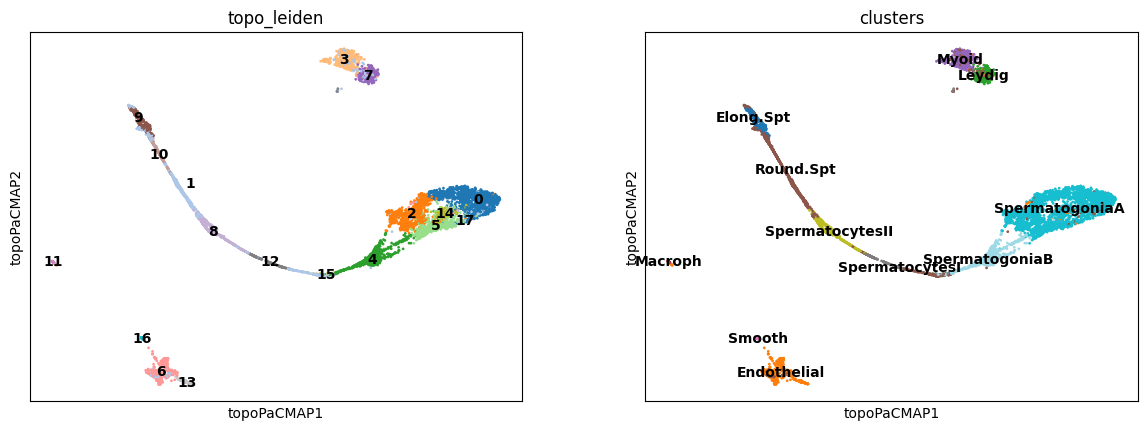

In [ ]:
sc.pl.embedding(adata, basis='topoPaCMAP', color=['topo_leiden','clusters'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

In [ ]:
adata

AnnData object with n_obs × n_vars = 7765 × 27897
    obs: 'batch', 'super_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'perc_mito', 'perc_MALAT1', 'n_genes', 'bw_adaptive from LE with bw_adaptive_leiden', 'topo_leiden', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Myoid_score', 'Smooth_Muscle_score', 'clusters'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'bw_adaptive from LE with bw_adaptive_leiden', 'topo_leiden_colors', 'clusters_colors'
    obsm: 'X_pca', 'X_umap', 'X_LE with bw_adaptive', 'X_MAP of bw_adaptive from LE with bw_adaptive', 

In [ ]:
adata.obsm['X_LE with bw_adaptive'].shape

(7765, 250)

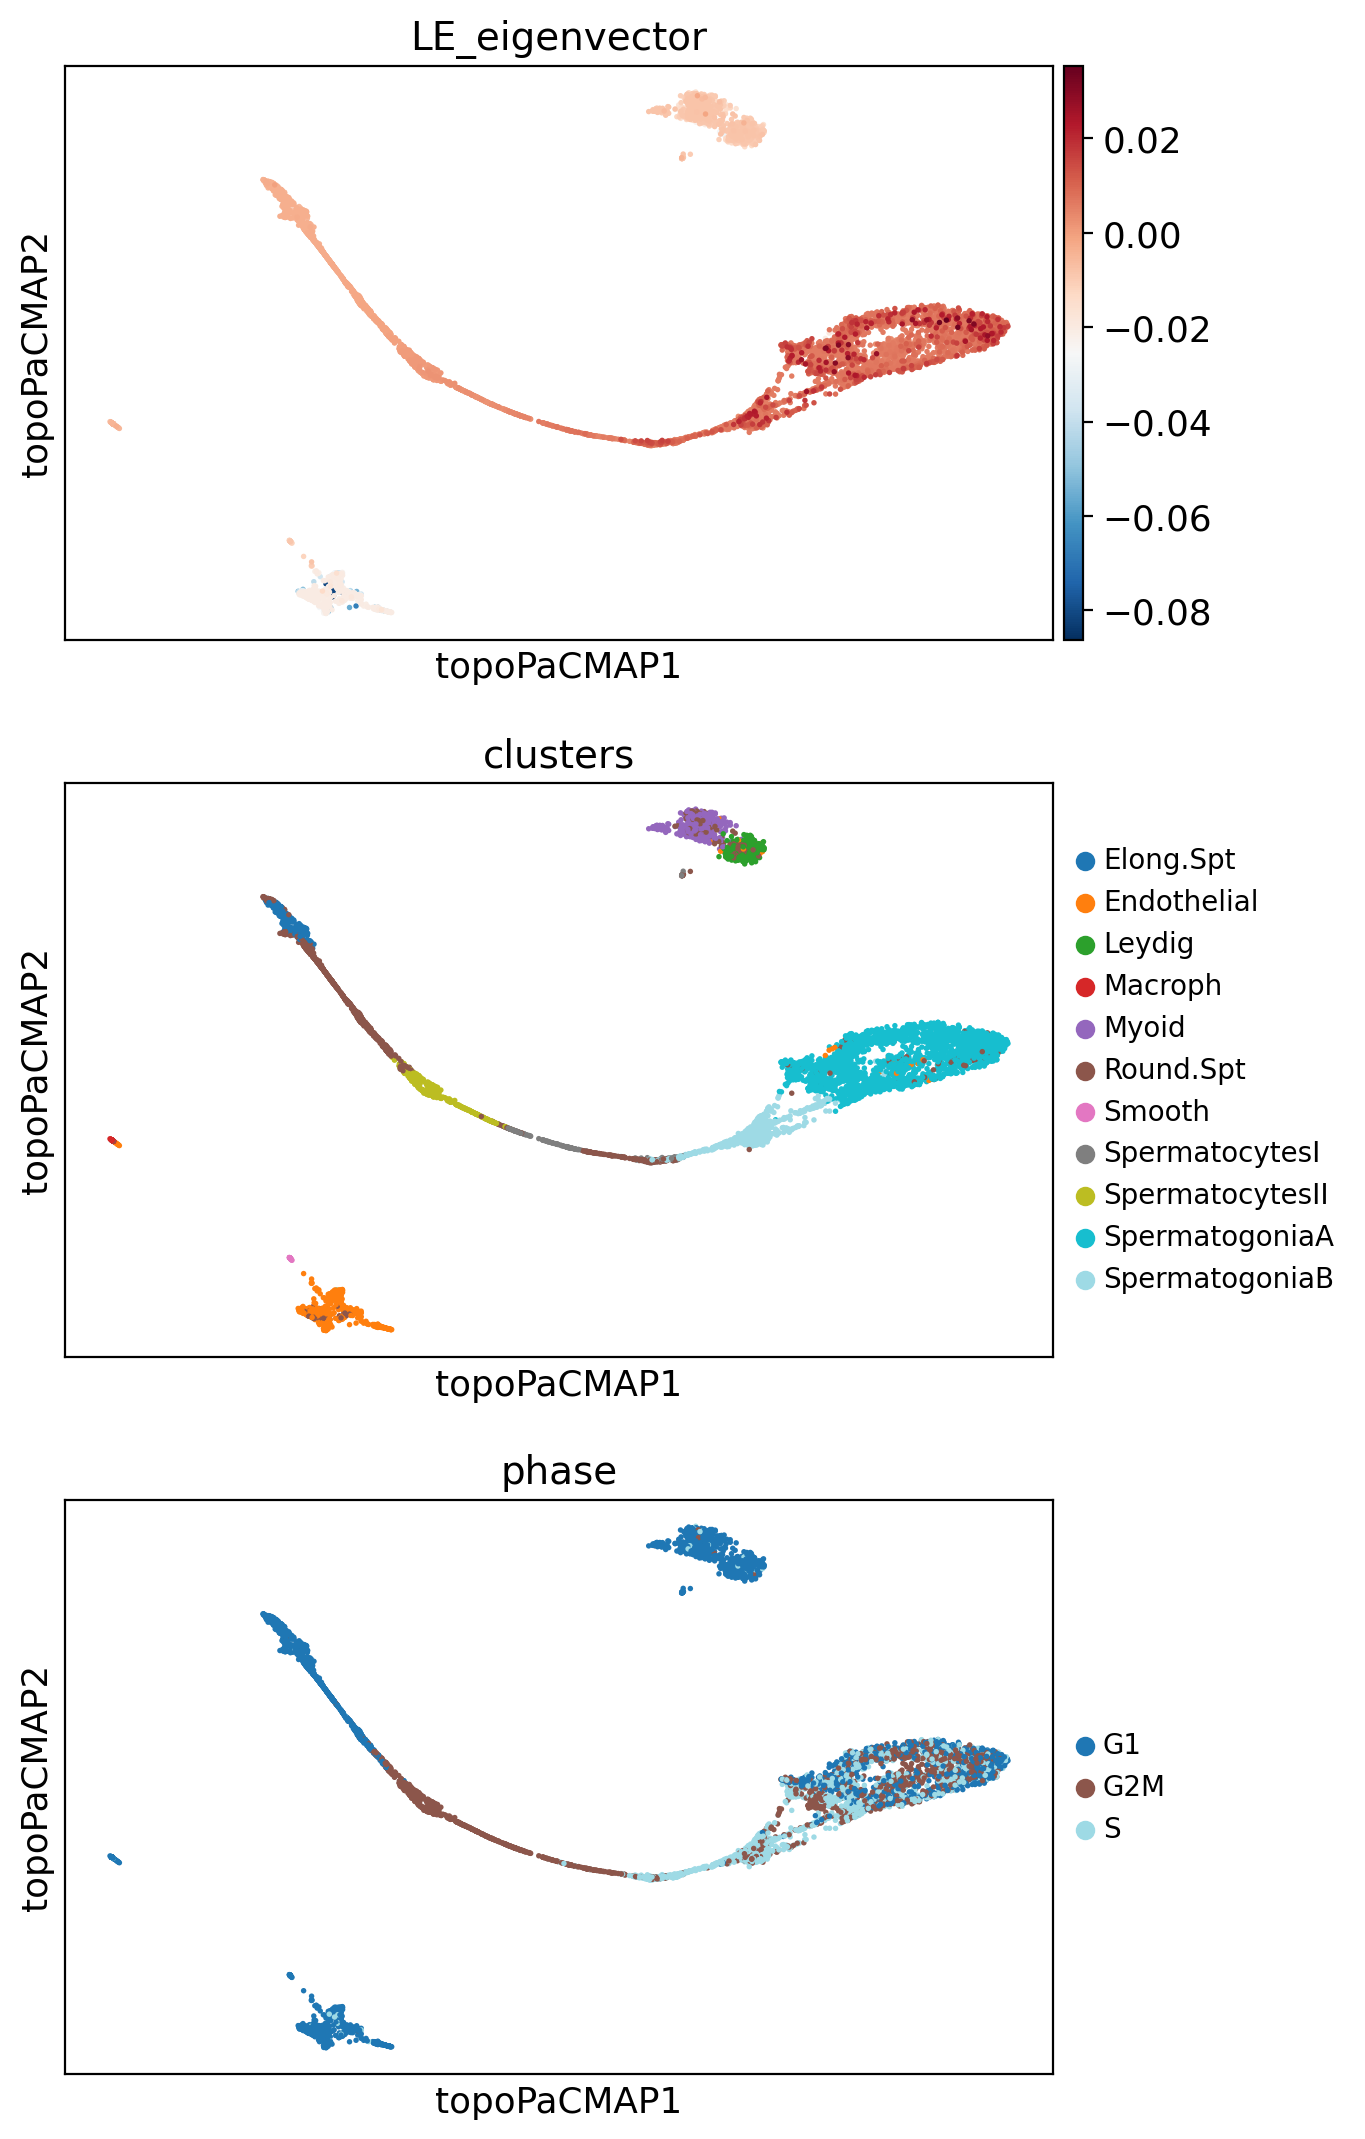

In [ ]:
dim=2
adata.obs['LE_eigenvector'] = adata.obsm['X_LE with bw_adaptive'][:,dim]

sc.pl.embedding(adata, basis='topoPaCMAP', color=['LE_eigenvector','clusters','phase'],
                 palette='tab20', ncols=1, legend_fontsize=10)

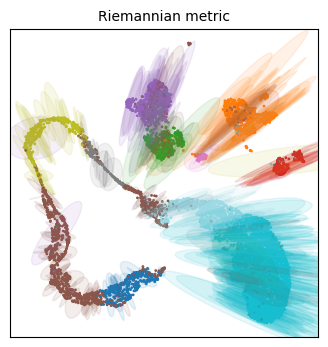

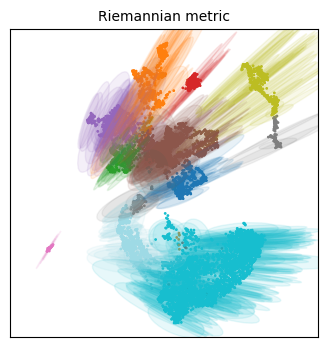

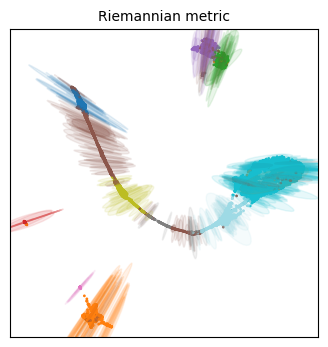

In [ ]:
# Get the graph Laplacian of our base graph kernel:
L = tg.base_kernel.L

# Define how many ellipses to plot:
n_plot = 500

# Convert the labels to integers:
labels = adata.obs['clusters'].cat.codes


# Name the projections you want to plot:
projections = ['umap', 'topoMAP', 'topoPaCMAP']

# Plot the Riemann metric
for name in projections:
    xy_coord = adata.obsm['X_' + name]
    tp.pl.plot_riemann_metric(xy_coord, # The coordinates of the projection
                              L,        # The graph Laplacian
                              std=0.5,  # A scaling factor for the ellipses size
                              n_plot=n_plot, # How many ellipses to plot
                              labels=labels,
                              cmap='tab20', # For coloring
                              random_state=tg.random_state, # For coloring
                              figsize=(4,4) # Size of the figure (NEEDS TO BE SQUARE!!!)
                             )